#### Author : Jeonghun Yoon

# Naive Bayes with TF_IDF를 이용하여 영화 리뷰를 예측하는 감정 분류기를 구현하라. 

In [1]:
import pandas as pd

## 1. Train, test set 구분

In [2]:
# 영화 리뷰를 load한다. 사랑/장르라는 단어를 포함하고 있는 document를 load 한다.
reviews = pd.read_csv('./inputs/ratings_train.txt', delimiter='\t')

In [3]:
# 데이터 확인
reviews.head(10)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
5,5403919,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.,0
6,7797314,원작의 긴장감을 제대로 살려내지못했다.,0
7,9443947,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단...,0
8,7156791,액션이 없는데도 재미 있는 몇안되는 영화,1
9,5912145,왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?,1


In [4]:
# Test set 로드
test_reviews = pd.read_csv('./inputs/ratings_test.txt', delimiter='\t')

In [5]:
# 데이터 확인
test_reviews.head(10)

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0
5,7898805,"음악이 주가 된, 최고의 음악영화",1
6,6315043,진정한 쓰레기,0
7,6097171,"마치 미국애니에서 튀어나온듯한 창의력없는 로봇디자인부터가,고개를 젖게한다",0
8,8932678,갈수록 개판되가는 중국영화 유치하고 내용없음 폼잡다 끝남 말도안되는 무기에 유치한c...,0
9,6242223,"이별의 아픔뒤에 찾아오는 새로운 인연의 기쁨 But, 모든 사람이 그렇지는 않네..",1


## 2. EDA

In [6]:
# 데이터의 크기
print('Train set', reviews.shape)
print('Test set', test_reviews.shape)

Train set (150000, 3)
Test set (50000, 3)


In [7]:
# Pos VS Neg dataset 개수 비교
reviews.label.value_counts()

0    75173
1    74827
Name: label, dtype: int64

In [8]:
# Pos VS Neg dataset 개수 비교
test_reviews.label.value_counts()

1    25173
0    24827
Name: label, dtype: int64

문장 길이의 분포를 살펴보자

In [9]:
import seaborn as sns

In [10]:
reviews['length'] = reviews['document'].apply(lambda x: len(str(x)))

In [11]:
reviews.head()

,id,document,label,length
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0,19
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1,33
2,10265843,너무재밓었다그래서보는것을추천한다,0,17
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0,29
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1,61


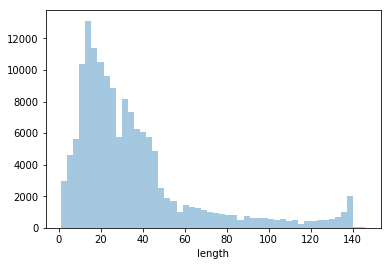

In [12]:
# 전체 분포
sns.distplot(reviews.length, kde=False)

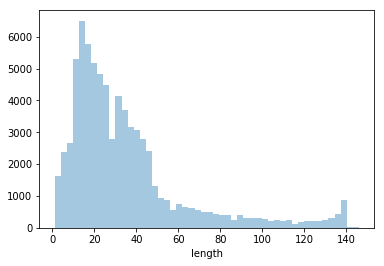

In [13]:
# Positive review에 대한 분포
sns.distplot(reviews[reviews.label==1]['length'], kde=False)

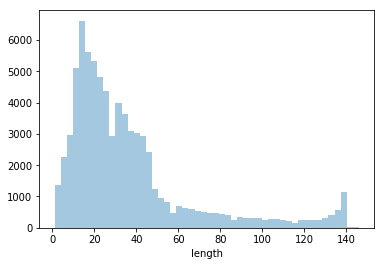

In [14]:
# Positive review에 대한 분포
sns.distplot(reviews[reviews.label==0]['length'], kde=False)

In [15]:
reviews.length.describe()

count    150000.000000
mean         35.203453
std          29.531983
min           1.000000
25%          16.000000
50%          27.000000
75%          42.000000
max         146.000000
Name: length, dtype: float64

In [16]:
reviews[reviews.length == 146]['document'].iloc[0]

'"스폰으로 먹고사는 방송이라 어쩔수 없다고 하지만. 이건 그냥 비현실적인 자동차만;...독일3사&슈퍼카 홍보 프로그램도 아니구.대중적인 자동차 방송으로 이루어 졌으면 합니다. 보는내내 ""카탈로그 책자""를 ""동영상으로 보여주는 방송"" 같아서 씁쓸하네요.!"'

문장길이 분포는 긍정/부정에 대한 차이가 크게 없다.

## 2. Text Pre-Processing
 - SKlearn에서 제공해주는 라이브러리를 사용할 것이며 해당 *parse* 메소드를 라이브러리에 넘겨줄 것이다.

In [17]:
# 형태소 분석기
import konlpy
from konlpy.tag import Okt

okt = Okt()

In [18]:
def parse(s):
    try:
        return okt.nouns(s)
    except:
        return []

In [19]:
reviews['parsed_doc'] = reviews.document.apply(parse)

In [20]:
reviews.head()

,id,document,label,length,parsed_doc
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0,19,"[더빙, 진짜, 목소리]"
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1,33,"[흠, 포스터, 보고, 초딩, 영화, 줄, 오버, 연기]"
2,10265843,너무재밓었다그래서보는것을추천한다,0,17,"[무재, 밓었, 다그, 래서, 추천]"
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0,29,"[교도소, 이야기, 구먼, 재미, 평점, 조정]"
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1,61,"[몬페, 의, 연기, 영화, 스파이더맨, 커스틴, 던스트]"


## 3. Vectorization (Bag-of-Words)
- Bag of words count를 vector로 만든다.
- Term frequency를 사용한다.
- ex) 전체 corpus가 `cat, love, i, do, like, him, you`라고 하자. 문장이 `i love you only you` 이면, 이 문장의 bag of word vector는 `(0, 1, 1, 0, 0, 0, 2)` 이다.

In [21]:
from sklearn.feature_extraction.text import CountVectorizer

In [22]:
bow_transformer = CountVectorizer(analyzer=parse) \
    .fit(reviews.document)

In [23]:
# Corpus
len(bow_transformer.vocabulary_)

38648

In [24]:
sample = reviews.document.iloc[3]
sample

'교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정'

In [25]:
sample_bow = bow_transformer.transform([sample])

In [26]:
print(sample_bow)

  (0, 2509)	1
  (0, 2630)	1
  (0, 26019)	1
  (0, 27667)	1
  (0, 29259)	1
  (0, 35255)	1


In [27]:
print(bow_transformer.get_feature_names()[2509])
print(bow_transformer.get_feature_names()[2630])
print(bow_transformer.get_feature_names()[26019])

교도소
구먼
이야기


In [28]:
reviews_bow = bow_transformer.transform(reviews.document)

In [29]:
# Sparse matrix의 크기
reviews_bow.shape

(150000, 38648)

In [30]:
# Non-zero의 발생 횟수
reviews_bow.nnz

847810

In [31]:
# Sparsity
sparsity = 100.0 * \
    reviews_bow.nnz / (reviews_bow.shape[0] * reviews_bow.shape[1])
print(round(sparsity, 3))

0.015


## 4. Normalization of vector (TF-IDF)

### 4.1. TF (Term Frequency)
Term Frequency, which measures how frequently a term occurs in a document. Since every document is different in length, it is possible that a term would appear much more times in long documents than shorter ones. Thus, the term frequency is often divided by the document length as a way of normalization:

$$TF(t)=\frac{\text{The number of times term t appears in a document}}{\text{The total number of terms in the document}}$$

### 4.2. IDF (Inverse Document Frequency)
Inverse Document Frequency, which measures how important a term is. While computing TF, all terms are considered equally important. However it is known that certain terms, such as "is", "of", and "that", may appear a lot of times but have little importance. Thus we need to weigh down the frequent terms while scale up the rare ones, by computing the following:

$$IDF(t)=log_{e}(\frac{\text{The total number of documents}}{\text{The number of documents with term t in it}})$$

(예시)
100개의 단어를 포함하고 있는 document를 생각해보자. "cat"이라는 단어가 그 document에 3번 나온다고 가정하자. 10,000,000의 문서 중에서 1,000의 문서에서만 "cat"이 나온다고 가정하자.
- TF : $3/100 = 0.03$
- IDF : $log_e(10,000,000 / 1,000)=4$
- TF-IDF : $0.03 \times 4 = 0.12$

In [32]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer().fit(reviews_bow)

In [33]:
sample_tfidf = tfidf_transformer.transform(sample_bow)
print(sample_tfidf)

  (0, 35255)	0.2229955053854873
  (0, 29259)	0.48387295041594
  (0, 27667)	0.24505937911070386
  (0, 26019)	0.27807555746194873
  (0, 2630)	0.5469932440848155
  (0, 2509)	0.5287326814292047


In [34]:
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['교도소']])
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['이야기']])

10.08518389566662
5.304085093270837


In [37]:
reviews_tfidf = tfidf_transformer.transform(reviews_bow)
reviews_tfidf.shape

(150000, 38648)

## 5. Training

In [35]:
from sklearn.naive_bayes import MultinomialNB

모델을 학습한다.

In [38]:
sentiment_detect_model = MultinomialNB().fit(reviews_tfidf, reviews['label'])

샘플데이터에 대하여 모델을 테스트해보자.

In [40]:
# 4번째 샘플에 대하여 예측값을 구해보자.
sentiment_detect_model.predict(sample_tfidf)[0]

0

In [44]:
# 4번째 샘플의 label
reviews['label'].iloc[3]

0

In [47]:
# 학습 데이터에 대하여 정확도를 체크해보자.
from sklearn.metrics import accuracy_score

train_preds = sentiment_detect_model.predict(reviews_tfidf)
train_preds[:10]

array([0, 0, 1, 0, 1, 0, 0, 0, 1, 1])

In [50]:
train_targets = reviews['label'].values

In [51]:
accuracy_score(train_targets, train_preds)

0.81092

## 6. Test

In [52]:
# Test set에 대한 bag of words vertors
test_reviews_bow = bow_transformer.transform(test_reviews.document)

In [53]:
# Test set에 대한 tf-idf vectors
test_reviews_tfidf = tfidf_transformer.transform(test_reviews_bow)

In [54]:
# NB 모델에서 예측
test_preds = sentiment_detect_model.predict(test_reviews_tfidf)

In [56]:
# Test 데이터 참 값
test_targets = test_reviews['label'].values

In [57]:
# Test data에서의 성능
accuracy_score(test_targets, test_preds)

0.76656